In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import DBSCAN
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else (torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu'))

### Train initial embedding on 'reference' dataset

In [2]:
def eval(dataset, model):
    output = []
    labels = []
    with torch.no_grad():
        for sample in dataset:
            img = sample['image']
            label = sample['label']
        
            batch_data = img.float().to(device)
            output.append(model(batch_data, embed=True).cpu().numpy())
            labels.append(label)
    output = np.concatenate(output,axis=0)
    labels = np.concatenate(labels,axis=0)
    return output, labels

In [3]:
from torchvision import transforms
from image_dataset_reader import HistImagesDataset

path_to_tissues = (
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_brain", 'label': 'brain', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_heart", 'label': 'heart', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_kidney", 'label': 'kidney', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_liver", 'label': 'liver', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_lung", 'label': 'lung', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_pancreas", 'label': 'pancreas', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_mouse_spleen", 'label': 'spleen', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/mt_rat_liver", 'label': 'liver_rat', 'ext': 'png'},
     )

n_samples_per_folder = 1000 # number of image samples to test on
tr_normalize = transforms.Normalize(mean=(0.5788, 0.3551, 0.5655), std=(1, 1, 1))
transforms_seq = transforms.Compose([transforms.ToTensor(), tr_normalize])
ref = HistImagesDataset(*path_to_tissues, n_samples=n_samples_per_folder, transform=transforms_seq)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5082118..0.64489996].


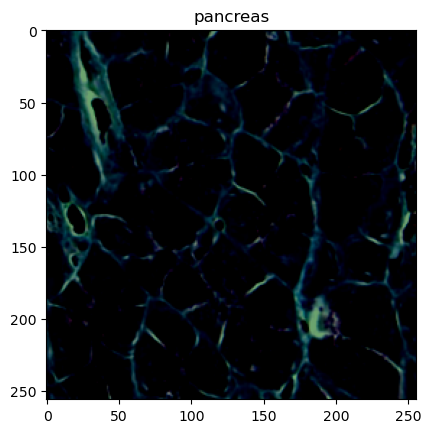

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.47138238..0.64489996].


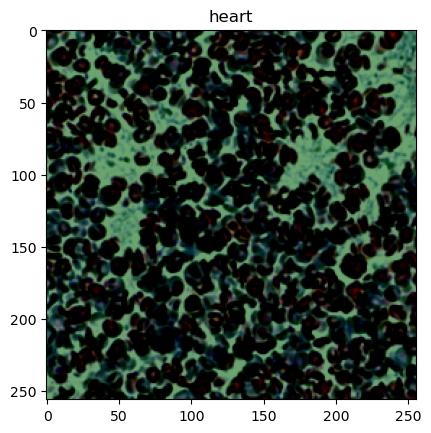

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5576569..0.64489996].


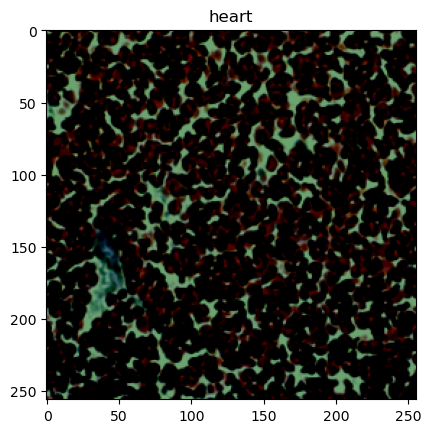

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.50036865..0.64489996].


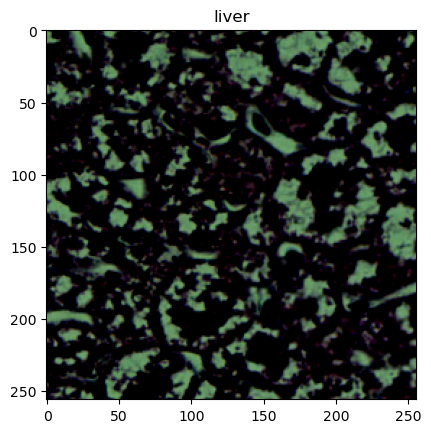

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4964471..0.64489996].


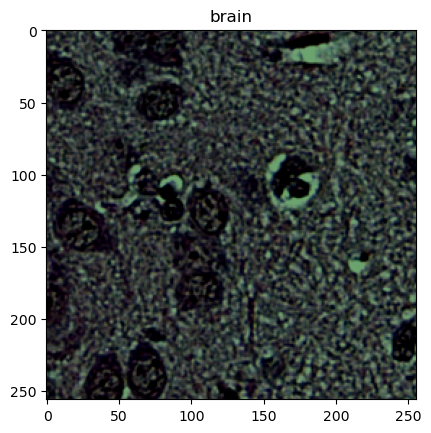

In [4]:
for i in range(5):
    img = ref[i]['image'].permute(1, 2, 0)
    img = img.numpy()
    plt.imshow(img)
    plt.title(ref[i]['string_label'])
    plt.show()

In [5]:
generator = torch.Generator().manual_seed(42)
trainset_ref, testset_ref = torch.utils.data.random_split(ref, [0.9,0.1], generator=generator)

  3%|▎         | 1/30 [00:35<17:21, 35.92s/it]

Epoch [1/30], Loss: 0.0962


  7%|▋         | 2/30 [00:42<08:35, 18.40s/it]

Epoch [2/30], Loss: 0.0952


 10%|█         | 3/30 [00:48<05:44, 12.78s/it]

Epoch [3/30], Loss: 0.0923


 13%|█▎        | 4/30 [00:54<04:23, 10.13s/it]

Epoch [4/30], Loss: 0.0910


 17%|█▋        | 5/30 [01:00<03:36,  8.67s/it]

Epoch [5/30], Loss: 0.0930


 20%|██        | 6/30 [01:06<03:07,  7.80s/it]

Epoch [6/30], Loss: 0.0906


 23%|██▎       | 7/30 [01:12<02:46,  7.23s/it]

Epoch [7/30], Loss: 0.0911


 27%|██▋       | 8/30 [01:18<02:30,  6.86s/it]

Epoch [8/30], Loss: 0.0905


 30%|███       | 9/30 [01:24<02:18,  6.61s/it]

Epoch [9/30], Loss: 0.0883


 33%|███▎      | 10/30 [01:30<02:08,  6.44s/it]

Epoch [10/30], Loss: 0.0881


 37%|███▋      | 11/30 [01:36<02:00,  6.33s/it]

Epoch [11/30], Loss: 0.0890


 40%|████      | 12/30 [01:42<01:52,  6.25s/it]

Epoch [12/30], Loss: 0.0868


 43%|████▎     | 13/30 [01:48<01:45,  6.19s/it]

Epoch [13/30], Loss: 0.0860


 47%|████▋     | 14/30 [01:54<01:38,  6.15s/it]

Epoch [14/30], Loss: 0.0862


 50%|█████     | 15/30 [02:01<01:32,  6.14s/it]

Epoch [15/30], Loss: 0.0906


 53%|█████▎    | 16/30 [02:07<01:25,  6.13s/it]

Epoch [16/30], Loss: 0.0876


 57%|█████▋    | 17/30 [02:13<01:19,  6.11s/it]

Epoch [17/30], Loss: 0.0849


 60%|██████    | 18/30 [02:19<01:13,  6.10s/it]

Epoch [18/30], Loss: 0.0851


 63%|██████▎   | 19/30 [02:25<01:07,  6.15s/it]

Epoch [19/30], Loss: 0.0843


 67%|██████▋   | 20/30 [02:31<01:01,  6.13s/it]

Epoch [20/30], Loss: 0.0831


 70%|███████   | 21/30 [02:37<00:54,  6.11s/it]

Epoch [21/30], Loss: 0.0841


 73%|███████▎  | 22/30 [02:43<00:48,  6.11s/it]

Epoch [22/30], Loss: 0.0817


 77%|███████▋  | 23/30 [02:49<00:42,  6.09s/it]

Epoch [23/30], Loss: 0.0847


 80%|████████  | 24/30 [02:55<00:36,  6.08s/it]

Epoch [24/30], Loss: 0.0838


 83%|████████▎ | 25/30 [03:01<00:30,  6.09s/it]

Epoch [25/30], Loss: 0.0810


 87%|████████▋ | 26/30 [03:08<00:24,  6.08s/it]

Epoch [26/30], Loss: 0.0804


 90%|█████████ | 27/30 [03:14<00:18,  6.08s/it]

Epoch [27/30], Loss: 0.0811


 93%|█████████▎| 28/30 [03:20<00:12,  6.07s/it]

Epoch [28/30], Loss: 0.0799


 97%|█████████▋| 29/30 [03:26<00:06,  6.07s/it]

Epoch [29/30], Loss: 0.0778


100%|██████████| 30/30 [03:32<00:00,  7.08s/it]

Epoch [30/30], Loss: 0.0793


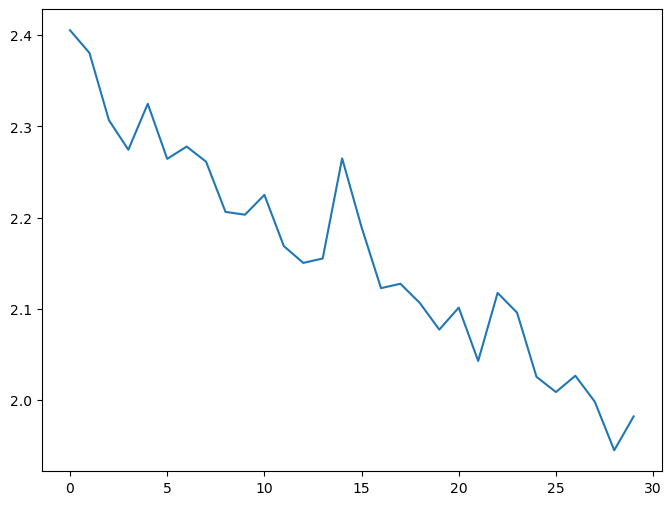

In [9]:
import sys
sys.path.append('../../')

from models.losses import SupervisedSimCLRLoss
from models.networks import CustomEfficientNet
from models.networks import MLP
from models.litmodels import SimCLRModel
from tqdm import tqdm

temp = 0.05
criterion = SupervisedSimCLRLoss(temperature=temp)
embed_dim = 4
embedder = CustomEfficientNet(fc_hidden=[128,128,128],fc_out=embed_dim, dropout=0.1).to(device)
projector = MLP(input_dim=embed_dim,hidden_dims=[embed_dim],output_dim=embed_dim).to(device)
model = SimCLRModel(embedder, projector).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 30
batch_size = 32
#dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
dataloader = DataLoader(testset_ref, batch_size=batch_size, shuffle=True)

losses = []
for epoch in tqdm(range(num_epochs)):
    model.train()
    epoch_loss = []
    for sample in dataloader:
        img = sample['image']
        labels = sample['label'].to(device)
        batch_data = img.float().to(device)

        # Potential to add any augmentation here
        features = model(batch_data).unsqueeze(1)
       
        # Compute SimCLR loss
        loss = criterion(features,labels=labels)
       
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
    mean_loss = np.mean(epoch_loss)
    losses.append(mean_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {mean_loss/len(dataloader):.4f}')
    

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(losses)),losses)

In [43]:
#torch.save(model.state_dict(), '/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/histology/model_4dim_mt.pth')
#model.load_from_checkpoint('/n/holystore01/LABS/iaifi_lab/Lab/phlab-neurips25/histology/model_4dim_mt.pth')

In [11]:
testloader = torch.utils.data.DataLoader(trainset_ref, batch_size=batch_size, shuffle=True)
ref_label, ref_embed = eval(testloader, model)

In [15]:
ref_label

array([[ 0.11883201, -3.57403   ,  0.5559069 ,  1.8571018 ],
       [ 0.33528993,  1.7309004 , -1.7243046 , -0.7654155 ],
       [-0.13735865, -0.56864685,  0.10094479,  0.4576337 ],
       ...,
       [-0.06536339, -2.4261532 ,  0.754472  ,  1.3022473 ],
       [ 0.5761192 ,  3.2199724 , -2.8858492 , -1.6446033 ],
       [ 0.01839018, -3.5432327 ,  0.72304654,  2.0263832 ]],
      shape=(7200, 4), dtype=float32)

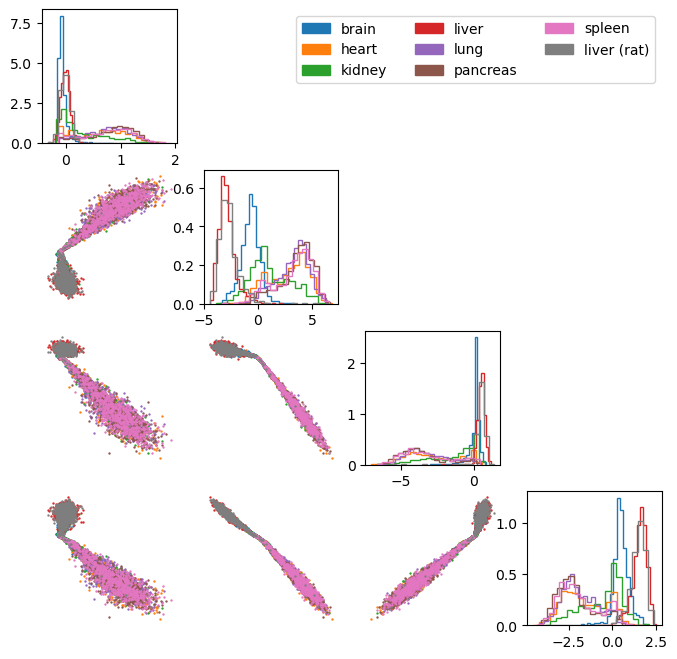

In [16]:
labelnames = {0:"brain", 1:"heart", 2:"kidney", 3:"liver", 4:"lung", 5:"pancreas", 6:"spleen", 7:"liver (rat)"}
from utils.plotting import make_corner
make_corner(ref_label, ref_embed, labelnames)

### Check domain shift before fine-tuning

In [17]:
path_to_tissues = (
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_brain", 'label': 'brain', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_heart", 'label': 'heart', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_kidney", 'label': 'kidney', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_liver", 'label': 'liver', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_lung", 'label': 'lung', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_pancreas", 'label': 'pancreas', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_mouse_spleen", 'label': 'spleen', 'ext': 'png'},
        {'folder': "/n/home11/nswood/anomaly-detection-in-histology/data/train/he_rat_liver", 'label': 'liver_rat', 'ext': 'png'},
     )

n_samples_per_folder = 1000 # number of image samples to test on
tr_normalize = transforms.Normalize(mean=(0.5788, 0.3551, 0.5655), std=(1, 1, 1))
transforms_seq = transforms.Compose([transforms.ToTensor(), tr_normalize])
dset_data = HistImagesDataset(*path_to_tissues, n_samples=n_samples_per_folder, transform=transforms_seq)

In [18]:
trainset_data, testset_data = torch.utils.data.random_split(dset_data, [0.9,0.1], generator=generator)

In [19]:
testloader = torch.utils.data.DataLoader(trainset_data, batch_size=batch_size, shuffle=True)
data_embed, data_label = eval(testloader, model)

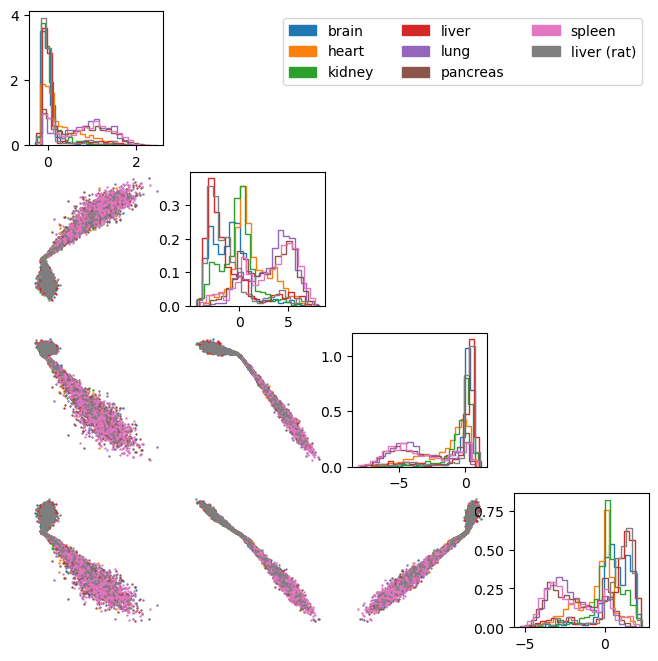

In [21]:
from utils.plotting import make_corner
make_corner(data_embed, data_label, labelnames)

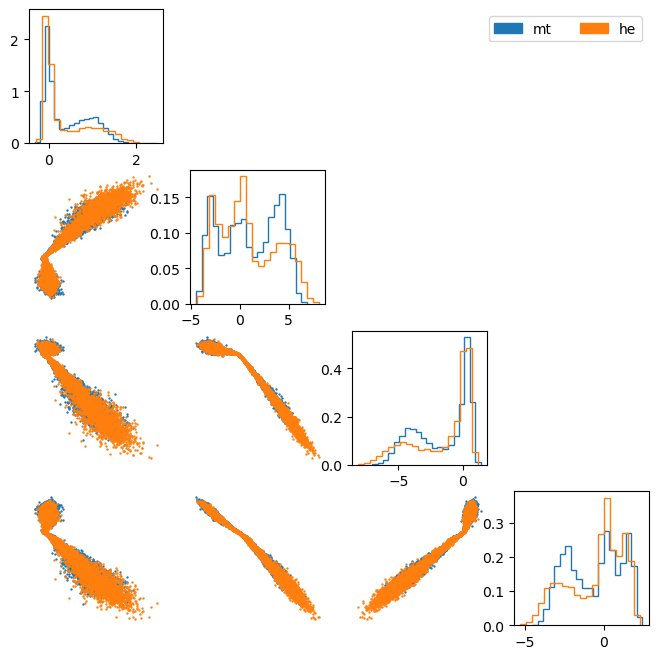

In [24]:
make_corner(np.concatenate([ref_label,data_embed],axis=0),
            labels=np.concatenate([np.zeros(len(ref_label)),np.ones(len(data_embed))]),
            label_names={0:"mt",1:"he"})

pancreas


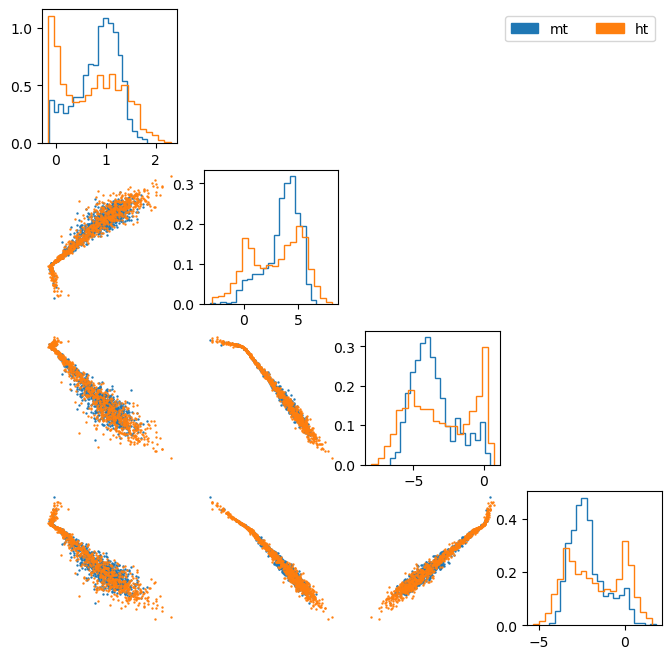

In [38]:
sel_label=5
regular = ref_label[ref_embed==sel_label]
shift = data_embed[data_label==sel_label]
print(labelnames[sel_label])
make_corner(np.concatenate([regular,shift],axis=0),
            labels=np.concatenate([np.zeros(len(regular)),np.ones(len(shift))]),
            label_names={0:"mt",1:"ht"})     

### Starting with the fine-tuning procedure...

In [42]:
from models.revgrad import GradientReversal
domain_classifier = MLP(4,[8,8],1,activation='relu')
domain_classifier = nn.Sequential(GradientReversal(alpha=1.0),domain_classifier)
domain_classifier = domain_classifier.to(device)